In [1]:
import sys

if sys.version_info.major == 3:
    print('OK')
elif sys.version_info.major == 2:
    print('ERROR: están usando python 2, deberían usar 3')
else:
  
    print('ERROR: wtf, qué versión de python es esta?')


OK


In [2]:
import numpy
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import keras
import h5py
import PIL
import seaborn as sns
import plotly
import sklearn_pandas
from google.colab import drive
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import learning_curve



drive.mount('/content/drive')

print('OK (puede salir algún warning, eso no sería problema)')


Mounted at /content/drive
OK (puede salir algún warning, eso no sería problema)


In [3]:
backend = keras.backend.backend()

if backend == 'tensorflow':
    print('OK')
else:
    print('ERROR: el backend de keras no es tensorflow, sino', backend)

OK


# Métricas

* La métrica que elegimos es Accuracy. La misma se define como el porcentaje de predicciones correctas realizadas por el modelo sobre el total de predicciones.
La elección de accuracy como métrica se fundamenta en que, en general, se busca predecir correctamente la victoria o derrota de un jugador en un partido de tenis. También nos brinda una medida directa de la capacidad del modelo para realizar predicciones correctas porcentualmente a los aciertos que tuvimos.



In [4]:
matches = pd.read_csv('/content/drive/MyDrive/machine learning/atp_matches_till_2022_mod.csv')
#matches = pd.read_csv('/content/drive/MyDrive/Universidad/5to año/Machine Learning/atp_matches_till_2022_mod.csv')
matches.shape

(188161, 50)

# Limpieza y acomodo de datos:

Eliminamos las variables que no se van a utilizar y transformamos las que si necesitamos. Además de darle un valor a los nulos.

* Surface: 





In [5]:
#surface: Eliminamos los nulos ya que son pocos valores

null_count = matches['surface'].isnull().sum()

print("Número de valores nulos en la columna 'surface':", null_count)

matches = matches.dropna(subset=['surface'])

matches.shape

Número de valores nulos en la columna 'surface': 2317


(185844, 50)

In [6]:
#tourney_level: Cantidad de nulos de toruney_level

null_count = matches['tourney_level'].isnull().sum()

print("Número de valores nulos en la columna 'tourney_level':", null_count)

#Como no hay nulos, no es necesario realizar ninguna acción por ahora

Número de valores nulos en la columna 'tourney_level': 0


In [7]:
#Transformamos p1_seed y p2_seed en enteros

import numpy as np

#transformamos p1_seed y p2_seed en enteros y poner los valores nulos en 0

matches['p1_seed'] = np.nan_to_num(matches['p1_seed'], nan=0, posinf=0, neginf=0)
matches['p2_seed'] = np.nan_to_num(matches['p2_seed'], nan=0, posinf=0, neginf=0)

matches['p1_seed'] = matches['p1_seed'].astype(int)
matches['p2_seed'] = matches['p2_seed'].astype(int)

#transformamos p1_ht y p2_ht en enteros y poner los valores nulos en 0

matches['p1_ht'] = np.nan_to_num(matches['p1_ht'], nan=0, posinf=0, neginf=0)
matches['p2_ht'] = np.nan_to_num(matches['p2_ht'], nan=0, posinf=0, neginf=0)

matches['p1_ht'] = matches['p1_ht'].astype(int)
matches['p2_ht'] = matches['p2_ht'].astype(int)

#transformamos p1_rank y p2_rank en enteros y poner los valores nulos en 0

matches['p1_rank'] = np.nan_to_num(matches['p1_rank'], nan=0, posinf=0, neginf=0)
matches['p2_rank'] = np.nan_to_num(matches['p2_rank'], nan=0, posinf=0, neginf=0)

matches['p1_rank'] = matches['p1_rank'].astype(int)
matches['p2_rank'] = matches['p2_rank'].astype(int)

#transformamos p1_age y p2_age en enteros y poner los valores nulos en 0

matches['p1_age'] = np.nan_to_num(matches['p1_age'], nan=0, posinf=0, neginf=0)
matches['p2_age'] = np.nan_to_num(matches['p2_age'], nan=0, posinf=0, neginf=0)

matches['p1_age'] = matches['p1_age'].astype(int)
matches['p2_age'] = matches['p2_age'].astype(int)

#Eliminamos p1_rank_points y p2_rank_points ya que hay demasiados datos faltantes

matches = matches.drop(columns=['p1_rank_points', 'p2_rank_points'])

In [8]:
#Eliminamos registros donde alguno de los jugadores es ambidiestro y donde alguno de los valores es nulo
matches = matches.drop(matches[(matches['p1_hand'] == 'U') | (matches['p2_hand'] == 'U')].index)
matches = matches.dropna(subset=['p1_hand', 'p2_hand'])


# # Creamos las columnas dummy para las variables 'p1_hand' y 'p2_hand'
# dummies_p1 = pd.get_dummies(matches['p1_hand'], prefix='p1')
# dummies_p2 = pd.get_dummies(matches['p2_hand'], prefix='p2')

# # Concatenamos las columnas dummy al DataFrame original
# matches = pd.concat([matches, dummies_p1, dummies_p2], axis=1)

# # Eliminamos las columnas originales 'p1_hand' y 'p2_hand'
# matches.drop(['p1_hand', 'p2_hand'], axis=1, inplace=True)

In [9]:
#Sacamos los best of 1 ya que son pocos y no tiene relevancia (no hay nulos)

matches = matches.drop(matches[matches['best_of'] == 1].index)

# dummies = pd.get_dummies(matches['best_of'])

# matches = pd.concat([matches, dummies], axis=1)

# matches.drop('best_of', axis=1, inplace=True)

In [10]:
#Dejamos solo el nombre "Davis cup" a los torneos que comiencen con ese string, ya que para cada enfrentamiento hay un nombre disitnto. Ej: Davis Cup ARG vs ESP

mask = matches['tourney_name'].str.startswith('Davis Cup')
matches.loc[mask, 'tourney_name'] = 'Davis Cup'


In [11]:
# Calculamos la altura promedio solo con los valores distintos de cero
avg_height = np.mean([height for height in matches[['p1_ht', 'p2_ht']].values.flatten() if height != 0])

avg_height = int(avg_height)

# Reemplazamos los valores 0 por la altura promedio
matches.loc[matches['p1_ht'] == 0, 'p1_ht'] = avg_height
matches.loc[matches['p2_ht'] == 0, 'p2_ht'] = avg_height


In [12]:
# Calculamos la edad promedio solo con los valores distintos de cero
avg_age = np.mean([height for height in matches[['p1_age', 'p2_age']].values.flatten() if height != 0])

avg_age = int(avg_age)

# Reemplazar los valores 0 por la edad promedio
matches.loc[matches['p1_age'] == 0, 'p1_age'] = avg_age
matches.loc[matches['p2_age'] == 0, 'p2_age'] = avg_age

In [13]:
# Para aquellos registros donde no se tenia dato de la cantidad de sets, definimos que sean 3 ya que es lo más común

matches['best_of'].fillna(3, inplace=True)


In [14]:
# Seleccionamos los registros en los que p1_rank y p2_rank no son 0 y los eliminamos del dataframe. Son muchos (más de 22 mil) pero no hay una forma certera de asignarle ranking a un jugador sin tener más datos.
matches = matches.query('p1_rank != 0 & p2_rank != 0')
matches = matches.dropna(subset=['p1_rank', 'p2_rank'])


In [15]:
# Eliminamos los registros que no utilizamos
columns_to_drop = ['tourney_id', 'tourney_name', 'tourney_date', 'p1_entry', 'round', 'p2_entry', 'p1_id', 'p2_id', 'draw_size', 'p1_name', 'p2_name', 'p1_ioc', 'p2_ioc', 'score', 'minutes', 'p1_ace', 'p2_ace', 'p1_df', 'p2_df', 'p1_svpt', 'p2_svpt', 'p1_1stIn', 'p2_1stIn', 'p1_1stWon', 'p2_1stWon', 'p1_2ndWon', 'p2_2ndWon', 'p1_SvGms', 'p2_SvGms', 'p1_bpSaved', 'p2_bpSaved', 'p1_bpFaced', 'p2_bpFaced']

matches = matches.drop(columns=columns_to_drop)


In [16]:
matches.shape

(139324, 15)

# Feature Engineering

* Creamos la nueva columna 'rank_diff' con la diferencia absoluta entre las posiciones de los jugadores

# Datos para el entrenamiento

* Dividimos los datos en conjunto de entrenamiento y conjunto de prueba

In [17]:
matches['rank_diff'] = abs(matches['p1_rank'] - matches['p2_rank'])

In [18]:
train, not_train = train_test_split(matches, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

train.shape, validation.shape, test.shape

((83594, 16), (27865, 16), (27865, 16))

In [19]:

train.dtypes

surface          object
tourney_level    object
match_num         int64
p1_seed           int64
p1_hand          object
p1_ht             int64
p1_age            int64
p2_seed           int64
p2_hand          object
p2_ht             int64
p2_age            int64
best_of           int64
p1_rank           int64
p2_rank           int64
winner            int64
rank_diff         int64
dtype: object

In [20]:
mapper = DataFrameMapper([
    (['p1_seed'], [StandardScaler()]),
    (['p2_seed'], [StandardScaler()]),
    (['p1_rank'], [StandardScaler()]),
    (['p2_rank'], [StandardScaler()]),
    (['surface'], [OneHotEncoder()]),
    (['best_of'], [OneHotEncoder()]),
    (['p1_ht'], [StandardScaler()]),
    (['p2_ht'], [StandardScaler()]),
    (['p1_age'], [StandardScaler()]),
    (['p2_age'], [StandardScaler()]),
    (['p1_hand'], [OneHotEncoder()]),
    (['p2_hand'], [OneHotEncoder()]),
])

mapper.fit(train)

DataFrameMapper(drop_cols=[],
                features=[(['p1_seed'], [StandardScaler()]),
                          (['p2_seed'], [StandardScaler()]),
                          (['p1_rank'], [StandardScaler()]),
                          (['p2_rank'], [StandardScaler()]),
                          (['surface'], [OneHotEncoder()]),
                          (['best_of'], [OneHotEncoder()]),
                          (['p1_ht'], [StandardScaler()]),
                          (['p2_ht'], [StandardScaler()]),
                          (['p1_age'], [StandardScaler()]),
                          (['p2_age'], [StandardScaler()]),
                          (['p1_hand'], [OneHotEncoder()]),
                          (['p2_hand'], [OneHotEncoder()])])

In [21]:

mapper_fe = DataFrameMapper([
    (['p1_seed'], [StandardScaler()]),
    (['p2_seed'], [StandardScaler()]),
    (['p1_rank'], [StandardScaler()]),
    (['p2_rank'], [StandardScaler()]),
    (['surface'], [OneHotEncoder()]),
    (['best_of'], [OneHotEncoder()]),
    (['p1_ht'], [StandardScaler()]),
    (['p2_ht'], [StandardScaler()]),
    (['p1_age'], [StandardScaler()]),
    (['p2_age'], [StandardScaler()]),
    (['p1_hand'], [OneHotEncoder()]),
    (['p2_hand'], [OneHotEncoder()]),
    (['rank_diff'], [StandardScaler()]),
])


mapper_fe.fit(train)

DataFrameMapper(drop_cols=[],
                features=[(['p1_seed'], [StandardScaler()]),
                          (['p2_seed'], [StandardScaler()]),
                          (['p1_rank'], [StandardScaler()]),
                          (['p2_rank'], [StandardScaler()]),
                          (['surface'], [OneHotEncoder()]),
                          (['best_of'], [OneHotEncoder()]),
                          (['p1_ht'], [StandardScaler()]),
                          (['p2_ht'], [StandardScaler()]),
                          (['p1_age'], [StandardScaler()]),
                          (['p2_age'], [StandardScaler()]),
                          (['p1_hand'], [OneHotEncoder()]),
                          (['p2_hand'], [OneHotEncoder()]),
                          (['rank_diff'], [StandardScaler()])])

In [22]:
def evaluate_model(model, set_names=('train', 'validation'), title='', show_cm=False):
    if title:
        display(title)
        
    final_metrics = {
        'Accuracy': [],       
    }
        
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]  # <- hack feo...

        y = set_data.winner
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))

        
        
        if show_cm:
            cm = metrics.confusion_matrix(y, y_pred)
            cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                                     display_labels=['loss', 'win'])
            cm_plot.plot(cmap="Blues")
        
    display(pd.DataFrame(final_metrics, index=set_names))

# Regresión Logística

'LR Simple Imputer sin FE'

,Accuracy
train,0.643982
validation,0.645685


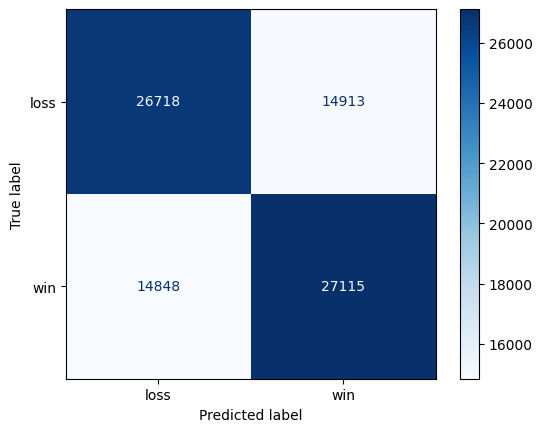

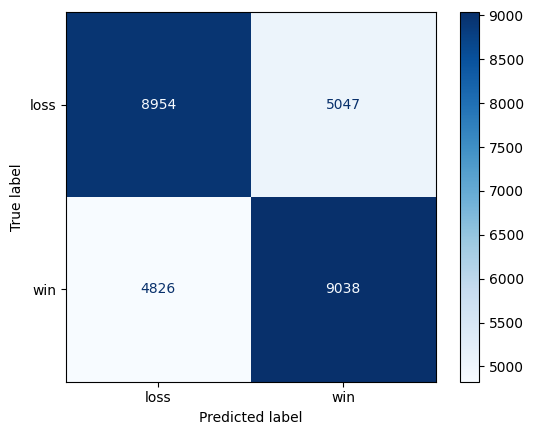

In [23]:
#Regresión Logistica

from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer, IterativeImputer

lr_model_si = Pipeline([
    ('mapper', mapper),
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', LogisticRegression(random_state=42)),
])

lr_model_si.fit(train, train.winner)

y_pred = lr_model_si.predict(validation)

evaluate_model(lr_model_si, title='LR Simple Imputer sin FE', show_cm=True)


'LR Simple Imputer con FE'

,Accuracy
train,0.643922
validation,0.645685


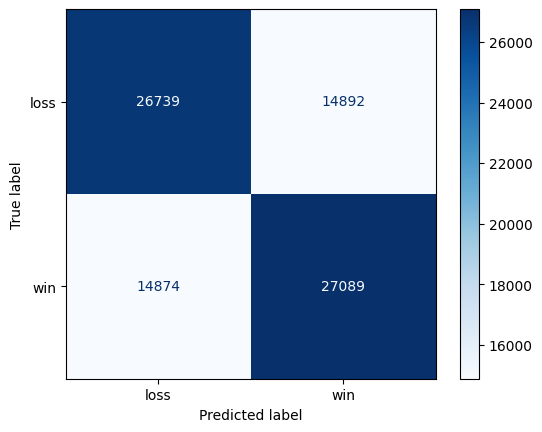

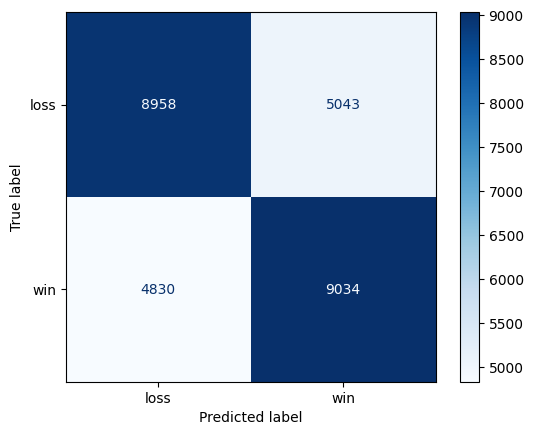

In [24]:
#Regresion Logistica con FE

from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer, IterativeImputer


lr_model_si_fe = Pipeline([
    ('mapper', mapper_fe),
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', LogisticRegression(random_state=42)),
])

lr_model_si_fe.fit(train, train.winner)

y_pred = lr_model_si_fe.predict(validation)

evaluate_model(lr_model_si_fe, title='LR Simple Imputer con FE', show_cm=True)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

'LR best model'

,Accuracy
train,0.643958
validation,0.645756


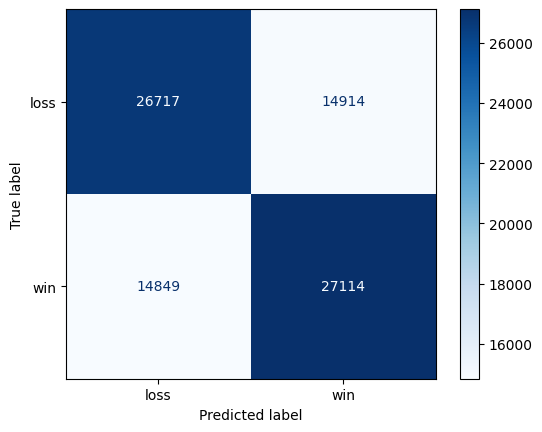

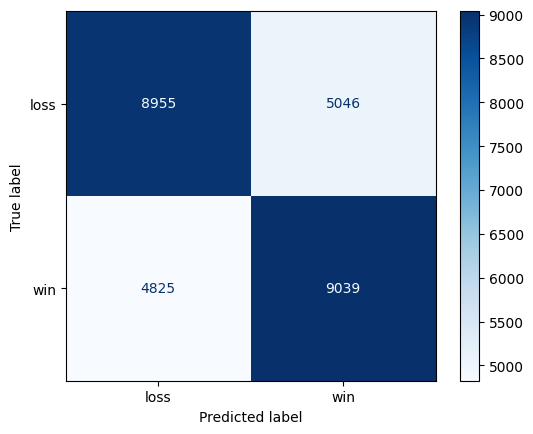

In [25]:
#Cambio hiper-parametros regresión logística

from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['liblinear', 'lbfgs', 'saga', 'newton-cg'],
    'classifier__max_iter': [100, 200, 300],
}

grid_search = GridSearchCV(lr_model_si, param_grid, cv=5)
grid_search.fit(train, train.winner)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(validation)
evaluate_model(best_model, title='LR best model', show_cm=True)


* Con el modelo de regresión logística el valor de accuracy es de 0.64 sobre el conjunto de los datos tanto cuando no usamos FE, como cuando la usamos y cuando utilizamos Hiper Parametros. Es decir, en el 64% de los casos se acertará el ganador. 




# KNN 

In [26]:
#K nearest neighbors sin FE

from sklearn.neighbors import KNeighborsClassifier
K = 10

knn_model = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

knn_model.fit(train, train.winner)

evaluate_model(knn_model, title='Knn')

'Knn'

,Accuracy
train,0.685827
validation,0.601651


In [27]:
#K nearest neighbors con FE

from sklearn.neighbors import KNeighborsClassifier
K = 10

knn_model = Pipeline([
    ('mapper', mapper_fe),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

knn_model.fit(train, train.winner)

evaluate_model(knn_model, title='Knn')

'Knn'

,Accuracy
train,0.687860
validation,0.605419


In [28]:
#knn con hiper-parametros

from sklearn.neighbors import KNeighborsClassifier

K = 5  # Cambia el valor de K según tus necesidades

knn_model = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

knn_model.fit(train, train.winner)

evaluate_model(knn_model, title='Knn')


'Knn'

,Accuracy
train,0.732588
validation,0.588588


* Utilizando para este modelo la FE encontramos el mismo valor de accuracy tanto para train como para validation, arrojando un 0.685827 y 0.601651 respectivamente. 
No encontramos los mismos datos utilizando Hiper Parámetros, ya que el valor de accuracy es de un 0.732588 en el conjunto de datos train y 0.588588 en validation. 

* Llegamos a la conclusion de que el modelo KNN con Hiper Parámetros muestra un rendimiento más alto en el conjunto de entrenamiento, pero un rendimiento inferior en el conjunto de validación, lo que indica la posibilidad de sobreajuste.

# Random Forest

In [29]:
#Random Forests sin FE

from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(random_state=42)
# n_estimators? max_depth=3?, max_features=2?

rf_model = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model),
])

rf_model.fit(train, train.winner)

evaluate_model(rf_model, title='Random Forest')

'Random Forest'

,Accuracy
train,0.999880
validation,0.646079


In [30]:
#Random Forests con FE

from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(random_state=42)
# n_estimators? max_depth=3?, max_features=2?

rf_model = Pipeline([
    ('mapper', mapper_fe),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model),
])

rf_model.fit(train, train.winner)

evaluate_model(rf_model, title='Random Forest')

'Random Forest'

,Accuracy
train,0.999868
validation,0.644428


In [31]:
#Random forest sin FE con Hiper-Parametros

from sklearn.ensemble import RandomForestClassifier

n_estimators = 100  # Número de árboles en el bosque
max_depth = None  # Profundidad máxima de cada árbol
max_features = 'auto'  # Número máximo de características a considerar en cada división

forest_model = RandomForestClassifier(
    random_state=42,
    n_estimators=n_estimators,
    max_depth=max_depth,
    max_features=max_features
)

rf_model = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model),
])

rf_model.fit(train, train.winner)

evaluate_model(rf_model, title='Random Forest con Hiper Parámetros')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


'Random Forest con Hiper Parámetros'

,Accuracy
train,0.999880
validation,0.646079


* A la hora de evaluar el modelo con random forest encontramos un accuracy en train	de un 0.999880 y validation	0.646079. En RF con FA y con Hiper Parámetros los resultados son muy similares, lo que significaria que acierta en un 99.9% de las veces el ganador del partido

# Regresión logística con PCA


In [32]:
d= 5
parameters = {'penalty': ['none', 'l1', 'l2']}
pca = PCA(n_components=d)

clasif = GridSearchCV(LogisticRegression(random_state=42), parameters, cv=5, scoring='accuracy')

modelo_pca_rl = Pipeline([
    ('mapper', mapper),
    ('pca', pca),
    ('classifier', clasif),
    
])

modelo_pca_rl.fit(train, train.winner)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:11

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['p1_seed'], [StandardScaler()]),
                                           (['p2_seed'], [StandardScaler()]),
                                           (['p1_rank'], [StandardScaler()]),
                                           (['p2_rank'], [StandardScaler()]),
                                           (['surface'], [OneHotEncoder()]),
                                           (['best_of'], [OneHotEncoder()]),
                                           (['p1_ht'], [StandardScaler()]),
                                           (['p2_ht'], [StandardScaler()]),
                                           (['p1_age'], [StandardScaler()]),
                                           (['p2_age'], [StandardScaler()]),
                                           (['p1_hand'], [OneHotEncoder()]),
                                           (['p2_hand'], [OneHotEncoder()])])),
                ('pca', PCA(n_components=5)),
                ('classifier',
                 GridSearchCV(cv=5,
                              estimator=LogisticRegression(random_state=42),
                              param_grid={'penalty': ['none', 'l1', 'l2']},
                              scoring='accuracy'))])

In [33]:
# Definir qué fracción de la varianza se quiere mantener
var_frac = 0.95

# Calcular la suma acumulativa
cumsum = np.cumsum(pca.explained_variance_ratio_) 
# eso nos dice cuanta información es retenida si paramos en cada dimensión

# En qué momento la suma cumulativa llega a var_frac * 100 %?
d = np.argmax(cumsum >= var_frac) + 1

Dimensiones: 18
Validacion cruzada: 0.6133574315135938
Mejores Hiperparametros: {'penalty': 'none'}


'Regresión Logistica con PCA'

,Accuracy
train,0.613082
validation,0.611915


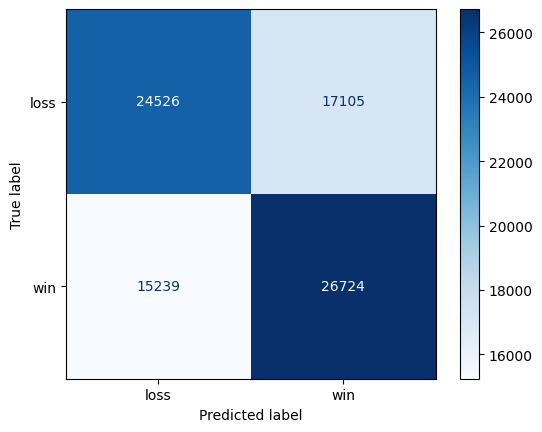

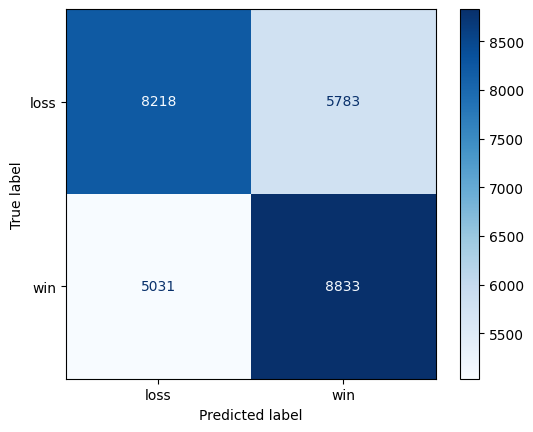

In [34]:
transformed_data = modelo_pca_rl.named_steps['mapper'].transform(train)
dimensiones = transformed_data.shape[1]
print("Dimensiones:", dimensiones)
print("Validacion cruzada:", clasif.best_score_)
print("Mejores Hiperparametros:", clasif.best_params_)

evaluate_model(modelo_pca_rl , title='Regresión Logistica con PCA', show_cm=True)

* El valor de Accuracy que devuelve la Regresión Logistica es del 61% de acierto. El mismo es menor al que nos devolvia el accuracy en el punto anterior por lo que nos conviene tener en cuenta y no este nuevo con PCA. 

# KNN con PCA

In [35]:

param_grid = {'n_neighbors': [5, 10, 15], 'weights': ['uniform', 'distance']}


pca = PCA(n_components=d)
K = 10

clasif = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')

modelo_pca_kkn = Pipeline([
    ('mapper', mapper),
    ('pca', pca),
    ('classifier', clasif),
    
])

modelo_pca_kkn.fit(train, train.winner)

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['p1_seed'], [StandardScaler()]),
                                           (['p2_seed'], [StandardScaler()]),
                                           (['p1_rank'], [StandardScaler()]),
                                           (['p2_rank'], [StandardScaler()]),
                                           (['surface'], [OneHotEncoder()]),
                                           (['best_of'], [OneHotEncoder()]),
                                           (['p1_ht'], [StandardScaler()]),
                                           (['p2_ht'], [StandardScaler()]),
                                           (['p1_age'], [StandardScaler()]),
                                           (['p2_age'], [StandardScaler()]),
                                           (['p1_hand'], [OneHotEncoder()]),
                                           (['p2_hand'], [OneHotEncoder()])])),
                ('pca', PCA(n_components=1)),
                ('classifier',
                 GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': [5, 10, 15],
                                          'weights': ['uniform', 'distance']},
                              scoring='accuracy'))])

Dimensiones: 18
Validacion cruzada: 0.502559955280317
Mejores Hiperparametros: {'n_neighbors': 5, 'weights': 'uniform'}


'KKN'

,Accuracy
train,0.688805
validation,0.501920


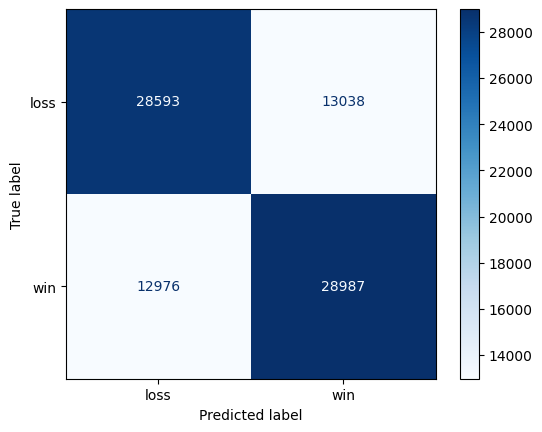

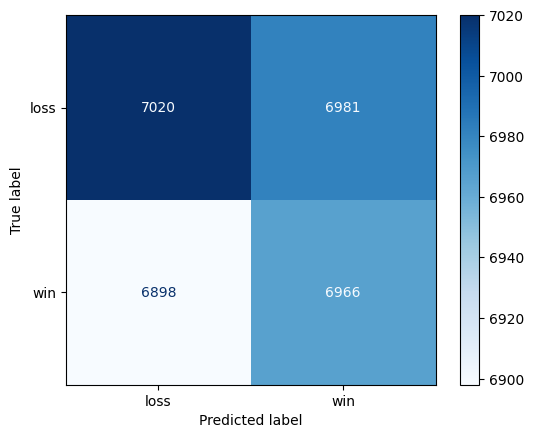

In [36]:
transformed_data = modelo_pca_kkn.named_steps['mapper'].transform(train)
dimensiones = transformed_data.shape[1]
print("Dimensiones:", dimensiones)
print("Validacion cruzada:", clasif.best_score_)
print("Mejores Hiperparametros:", clasif.best_params_)

evaluate_model(modelo_pca_kkn , title='KKN', show_cm=True)

* Podemos observar que el valor de accuracy en este caso es del 68% para el conjunto de datos train, por lo que la metrica no se ve beneficiada luego de utilizar PCA comparado con el modelo que utiliza KNN con hiper parametros, ya que ahi encontramos la mejora accuracy.

# Random Forest con PCA


In [ ]:
param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 3, 6]}

pca = PCA(n_components=d)

clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')

modelo_pca_rf = Pipeline([
    ('mapper', mapper),
    ('pca', pca),
    ('classifier', clf)
])

modelo_pca_rf.fit(train, train.winner)


In [ ]:
transformed_data = modelo_pca_rf.named_steps['mapper'].transform(train)
dimensiones = transformed_data.shape[1]
print("Dimensiones:", dimensiones)
print("Validacion cruzada:", modelo_pca_rf.best_score_)
print("Mejores Hiperparametros:", modelo_pca_rf.best_params_)

evaluate_model(modelo_pca_rf, title='Random Forest', show_cm=True)


# Técnicas para evitar el sobreentrenamiento

* Empleamos estrategias de división de datos, validación cruzada y reducción de dimensionalidad para mejorar la capacidad de generalización y rendimiento de los modelos. 
* Estas técnicas ayudaron a seleccionar las mejores configuraciones y características relevantes, evitando problemas como el sobreajuste y mejorando la eficiencia del modelo.

# Modelo elegido

* El modelo que mejor acertó el ganador es el Random Forest, en un 99,9% de los casos acertaba. Por lo que definimos que es el mejor para utilizar ya que los resultados que podemos ver son mejores comparando los demas modelos que entrenamos. 

In [ ]:
# # Árboles de Decisión
# param_grid_dt = {
#     'max_depth': [None, 5, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Regresión Logística
# param_grid_lr = {
#     'C': [0.1, 1.0, 10.0],
#     'penalty': ['l1', 'l2'],
#     'tol': [0.001, 0.01, 0.1]
# }

# # Random Forest
# param_grid_rf = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 5, 10],
#     'min_samples_split': [2, 5, 10]
# }


# le = LabelEncoder()
# train['winner'] = le.fit_transform(train['winner'])

# # Árboles de Decisión
# dt_model = DecisionTreeClassifier()
# dt_grid_search = GridSearchCV(dt_model, param_grid_dt, cv=5)

# # Regresión Logística
# lr_model = LogisticRegression()
# lr_grid_search = GridSearchCV(lr_model, param_grid_lr, cv=5)

# # Random Forest
# rf_model = RandomForestClassifier()
# rf_grid_search = GridSearchCV(rf_model, param_grid_rf, cv=5)

# train = train.astype(str)
# train['winner'] = train['winner'].astype(str)

# train.columns = train.columns.astype(str)
# error_score='raise'

# # Árboles de Decisión
# dt_grid_search.fit(train, train['winner'])

# # Regresión Logística
# lr_grid_search.fit(train, train['winner'])
# # Random Forest
# #rf_grid_search.fit(train, train['winner'])

# # Árboles de Decisión
# best_params_dt = dt_grid_search.best_params_
# best_model_dt = dt_grid_search.best_estimator_

# # Regresión Logística
# best_params_lr = lr_grid_search.best_params_
# best_model_lr = lr_grid_search.best_estimator_

# # Random Forest
# #best_params_rf = rf_grid_search.best_params_
# #best_model_rf = rf_grid_search.best_estimator_


In [ ]:
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)
pca.fit(X)
print("Importancias de las nuevas dimensiones:", pca.explained_variance_ratio_)  
nX = pca.transform(X)

In [ ]:
# train.columns = train.columns.astype(str)
# train = train.astype(str)
# print (matches.info())


In [ ]:
# # Árboles de Decisión
# param_grid_dt = {
#     'max_depth': [None, 5, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Regresión Logística
# param_grid_lr = {
#     'C': [0.1, 1.0, 10.0],
#     'penalty': ['l1', 'l2'],
#     'tol': [0.001, 0.01, 0.1]
# }

# # Random Forest
# param_grid_rf = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 5, 10],
#     'min_samples_split': [2, 5, 10]
# }


# le = LabelEncoder()
# train['winner'] = le.fit_transform(train['winner'])

# # Árboles de Decisión
# dt_model = DecisionTreeClassifier()
# dt_grid_search = GridSearchCV(dt_model, param_grid_dt, cv=5)

# # Regresión Logística
# lr_model = LogisticRegression()
# lr_grid_search = GridSearchCV(lr_model, param_grid_lr, cv=5)

# # Random Forest
# rf_model = RandomForestClassifier()
# rf_grid_search = GridSearchCV(rf_model, param_grid_rf, cv=5)

# train = train.astype(str)
# train['winner'] = train['winner'].astype(str)

# train.columns = train.columns.astype(str)
# error_score='raise'

# # Árboles de Decisión
# dt_grid_search.fit(train, train['winner'])

# # Regresión Logística
# lr_grid_search.fit(train, train['winner'])
# # Random Forest
# #rf_grid_search.fit(train, train['winner'])

# # Árboles de Decisión
# best_params_dt = dt_grid_search.best_params_
# best_model_dt = dt_grid_search.best_estimator_

# # Regresión Logística
# best_params_lr = lr_grid_search.best_params_
# best_model_lr = lr_grid_search.best_estimator_

# # Random Forest
# #best_params_rf = rf_grid_search.best_params_
# #best_model_rf = rf_grid_search.best_estimator_
